# Activity 4.1. EM for GMM

(last modified 17 April 2023)

This laboratory activity should take around 2 hours to complete.

## Learning Outcomes

In this activity you will learn to:
- Generate Symmetric Positive-Definite Matrices
- Explore Unsupervised Learning Models, specifically Gasussian Mixture Models
- Explore the differences between Hard and Soft Expectation Maximimization


## Prerequisites

- Module 3
- Lecture 7

## Background: Gaussian Mixture Models (GMM)

A probabilistic or soft clustering model assigns conditional probabilities to cluster labels $\{1, \dots, K\}$ given a data point $\boldsymbol{x} \in \mathbb{R}^d$. By considering the cluster membership as random variable $Z$, such a model is principally the same as a probalistic classification model by describing the conditional distribution $Z \, | \, X$. However, the fundamental additional challenge is that we aim to train it without having access to any $Z$-values, i.e., as an unsupervised learning approach.
Still, this is a difference that only matters on the level of the learning algorithm and not on the level of the model definition.

Specifically, the Gaussian mixture model has a definition that is virtually identical to the Bayesian classifier discussed previously. Specifically, for $K$ clusters (previously ``classes''), its combined parameters $\boldsymbol{\theta}=(\boldsymbol{\varphi}, \boldsymbol{\mu}_1, \boldsymbol{\Sigma}_1, \dots, \boldsymbol{\mu}_K, \boldsymbol{\Sigma}_k)$ consist of 

- cluster/class priors $\boldsymbol{\varphi}=(\varphi_1, \dots, \varphi_K) \in \mathbb{R}_+$ with $\varphi_1+\dots+\varphi_K=1$
- $K$ mean vectors $\boldsymbol{\mu}_k \in \mathbb{R}^2$ and covariance matrices $\boldsymbol{\Sigma}_k \in \mathbb{R}^{d,d}$

and the model is defines the conditonal distribution $Z \,|\, X$ via the probability mass function
\begin{equation*}
p(k \,|\, \boldsymbol{x}, \boldsymbol{\theta}) = \frac{\varphi_k \,p(\boldsymbol{x} \, | \, \boldsymbol{\mu}_k, \boldsymbol{\Sigma}_k)}{\sum_{l=1}^K \varphi_l \, p(\boldsymbol{x} \, | \, \boldsymbol{\mu}_l, \boldsymbol{\Sigma}_l)}
\end{equation*}
where $p(\boldsymbol{x} \, | ,\ \boldsymbol{\mu}_k, \boldsymbol{\Sigma}_k)$ is the probability density of the multi-variate normal distribution with mean vector $\boldsymbol{\mu}$ and covariance matrix $\boldsymbol{\Sigma}$.

Now, as mentioned above, the goal is to fit this model to a set of iid observations of only $X$-values, $\{\boldsymbol{x}_1, \dots, \boldsymbol{x}_N\}$, which we can also compactly denote as a data matrix $\boldsymbol{X} \in \mathbb{R}^{N \times d}$. Given that we are again dealing with a probabilistic model, it is natural to aim to achieve this using maximum likelihood parameter estimation, i.e., by finding parameters $\boldsymbol{\theta}$ that maximise $p(\boldsymbol{X} \, | \, \boldsymbol{\theta})$.

## Synthetic Data Generation

In this lab we will be making use of the make_gaussian_mixture_data function from Activity 3 to sample data from a Gaussian Mixture. 

### Task A: Sample and Plot Data

Consider the following datasets which we will be using for the duration of this lab. What do you notice about them? How are they different?

In [5]:
import numpy as np
from Activity4 import make_gaussian_mixture_data
import matplotlib.pyplot as plt

def plot_scatter_by_label(X, y, ax=None, title=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1)
        fig.set_figheight(6)
        fig.set_figwidth(8)
    categories = np.unique(y)
    for cat in categories:
        ax.scatter(X[y==cat, 0], X[y==cat, 1], label='Cluster {0}'.format(cat), alpha=0.25)
        ax.scatter(np.mean(X[y==cat, 0]), np.mean(X[y==cat, 1]), c='k', marker='x', s=200)
    ax.set_xlabel('X0', size=15)
    ax.set_ylabel('X1', size=15)
    ax.set_title(title if title else "Gaussian Mixture", size=20)
    plt.legend()
    return ax

No handles with labels found to put in legend.


<AxesSubplot:title={'center':'Non Separable Data'}, xlabel='X0', ylabel='X1'>

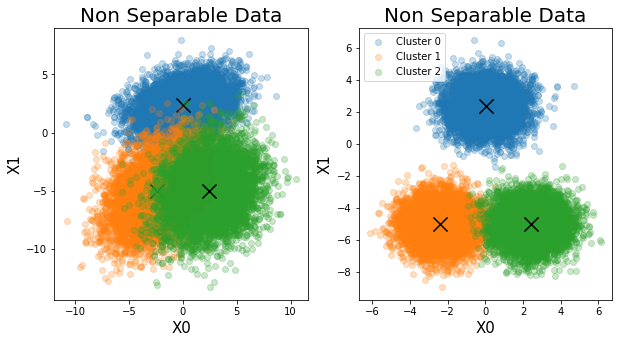

In [6]:
mu0 = 5*np.array([0, np.arctan(np.pi/6)])
mu1 = 5*np.array([np.arctan(-np.pi/6), -1])
mu2 = 5*np.array([np.arctan(np.pi/6), -1])

cov0 = np.array([[5, 1], [1, 2]])
cov1 = np.array([[5, 2], [2, 5]])
cov2 = np.array([[5, 1], [1, 5]])

means = [mu0, mu1, mu2]

covs = [cov0, cov1, cov2]

class_probs = np.array([1, 1, 1])/3

N = 20000
K=3

X_train, y_train = make_gaussian_mixture_data(n=N, means=means, covs=covs, class_probs=class_probs, random_state=0)
X_test, y_test = make_gaussian_mixture_data(n=10000, means=means, covs=covs, class_probs=class_probs, random_state=0)

X_train_sep, y_train_sep = make_gaussian_mixture_data(n=N, means=means, covs=None, class_probs=class_probs, random_state=0)
X_test_sep, y_test_sep = make_gaussian_mixture_data(n=10000, means=means, covs=None, class_probs=class_probs, random_state=0)

fig, axs = plt.subplots(1, 2)
fig.set_figwidth(10)
fig.set_figheight(5)
plot_scatter_by_label(X_train, y_train, ax=axs[0], title='Non Separable Data')
plot_scatter_by_label(X_train_sep, y_train_sep, ax=axs[1], title='Non Separable Data')

### Task B: Implement Gaussian Mixture Model with Expectation Maximisation

The Expectation Maximisation (EM) algorithm is an iterative parameter fitting algorithm in the context of hidden (latent, unseen) variables, which is useful in settings where it would be easy to maximise the likelihood function were the values of those hidden variables known. Abstractly, the idea of the algorithm is as follows:

- start with some initial guess for the parameters $\boldsymbol{\theta}^{(0)}$
- iteratively, find new parameter values $\boldsymbol{\theta}^{(i+1)}$ by maximising the **expected log likelihood** $\mathbb{E}[\sum_{n=1}^N \ln p(\boldsymbol{x}_n, Z_n \, | \, \boldsymbol{\theta}^i)]$ where the expected value is taken over the distribution of the hidden $Z_n$ according to the current parameter guess $\boldsymbol{\theta}^{(i)}$
- stop when the parameters themselves or the likelihood $p(\boldsymbol{X} \, |\, \boldsymbol{\theta})$ do not change any more substantially

The idea of optimising the expected log likelihood with respect to the hidden variables is what gives the algorithm its name. This is typically decomposed further into an E-step, where one computes the probabilities required to evaluate the expected log likelihood function, and an M-step, where one computes the new parameter values. Specifically, for the GMM, these steps are defined as follows:

- E-step: compute the probabilities $r_{n, k}=p(k \, | \, \boldsymbol{x}_n, \boldsymbol{\theta}^{(i)})$ of the $n$-th data point to belong to cluster $k$ according to the current parameter guess
- M-step: compute for all $k \in \{1, \dots, K\}$
\begin{align*}
\boldsymbol{\mu}_k^{(i+1)} &= \frac{1}{N_k}\sum_{n=1}^N r_{n,k}\boldsymbol{x}_n\\
\boldsymbol{\Sigma}_k^{(i+1)} &= \frac{1}{N_k}\sum_{n=1}^N r_{n,k}(\boldsymbol{x}_n - \boldsymbol{\mu}_k^{(i+1)})(\boldsymbol{x}_n - \boldsymbol{\mu}_k^{(i+1)})^T\\
\boldsymbol{\varphi_k} &= N_k/N
\end{align*}
where $N_k=\sum_{n=1}^N r_{n,k}$.

Complete the following implementation of GMM via the EM algorithm by completing the methods `fit` and `predict_proba`, which returns the computed cluster membership probabilities according to the model fit.

Note that `self.r_historic_` and `self.Mu_hat_historic_` are being used to track the intermediate steps of the fitting process. This is not necessary for the algorithm but will be useful later to create some visualisations. 



In [7]:
from scipy.stats import multivariate_normal
class SoftGMM: 
    def __init__(self, K, tau_max=200, epsilon=0.01, random_state=None):
        self.K = K               # number of GMM clusters
        self.tau_max = tau_max   # max number of iterations
        self.epsilon = epsilon  # minimum acceptable error rate
        self.random_state = random_state
        np.random.seed(self.random_state)

    def get_params(self, deep=False):
        return {'K': self.K,
         'tau_max': self.tau_max,
         'epsilon': self.epsilon,
         'random_state': self.random_state}
    
    def __str__(self):
        params = self.get_params()
        return 'SoftGMM({0})'.format(','.join(['='.join([key, str(params[key])]) for key in params.keys()]))

    def __repr__(self):
        return self.__str__()
                
    def fit(self, X, verbose=False):
        N = X.shape[0]
        ## initialization:
        self.Psi_hat_ = np.array([1/self.K] * self.K)                         # assume all clusters have the same prob (we will update this later on)
        self.Nk_hat_ = self.Psi_hat_ * N                                       
        self.Mu_hat_ = X[np.random.choice(N, size=self.K, replace=False)]   # randomly  choose K samples as cluster means (any better idea?)
        self.Sigma_hat_ = np.array([np.eye(X.shape[1]) for _ in range(self.K)])     # create identity covariance matrices as initialization
        r = np.zeros((N,self.K))                                     # empty posterior matrix (the membership estimates will be stored here)                
        
        self.Mu_hat_historic_ = np.zeros(shape=(list(self.Mu_hat_.shape) + [self.tau_max]))
        self.r_historic_ = np.zeros(shape=(N, self.K, self.tau_max))

        terminate= False
        tau = 0
        # fitting loop - we iteratively take E and M steps until the termination criterion is met.
        Mu_hat_old = self.Mu_hat_ # Mu_hat_old is used to store the last iteration value for mu_hat
        while (not terminate):
            if verbose: print('iteration {0}'.format(tau))
            # E step:
            ### YOUR CODE HERE ###



            ### END YOUR CODE HERE ###
            r = r/r.sum(axis=1,keepdims=True) # normalization (to make sure sum(r)=1)
            self.r_historic_[:, :, tau] = r

            # M step
            self.Nk_hat_ = r.sum(axis=0)
            self.Psi_hat_ = self.Nk_hat_/N
            ### YOUR CODE HERE ###



            ### END YOUR CODE HERE ###
            self.Mu_hat_historic_[:, :, tau] = self.Mu_hat_
            tau +=1

            terminate = ((tau == self.tau_max) or np.allclose(self.Mu_hat_, Mu_hat_old, rtol= self.epsilon))
            Mu_hat_old = self.Mu_hat_

        self.Mu_hat_historic_ = self.Mu_hat_historic_[:, :, :tau]
        self.r_historic_ = self.r_historic_[:, :, :tau]

        if verbose: print(f'Converged in {tau} iterations')

        return self
        
        
    def predict_proba(self, x):
        N = x.shape[0]
        r = np.zeros((N,self.K))
        ### YOUR CODE HERE ###



        ### END YOUR CODE HERE ###
        r = r/r.sum(axis=1,keepdims=True) # normalization (to make sure sum(r)=1)
        return r

    def predict(self, x):
        probs = self.predict_proba(x)
        preds = np.argmax(probs, axis=1)
        return preds


## Task C: Evaluate the Model

Let's use the self.r_historic_ and self.Mu_hat_historic_ variables to oberve how our model fit evolves during the fitting procedure.

- What do you notice as the number of iterations increases? 
- What differences do you see between the two datasets?

In [8]:
def plot_gmm(gmm, x, gran=3):
    idxs = np.arange(start=0, stop=gmm.r_historic_.shape[-1], step=gran)
    n_plots = len(idxs)
    rows = int(np.sqrt(n_plots))
    cols = int(n_plots//rows) + 1
    fig, axs = plt.subplots(rows, cols)
    fig.set_figheight(5*rows)
    fig.set_figwidth(5*cols)
    for i, idx in enumerate(idxs):
        if not(1 in (rows, cols)):
            j = int(i//cols)
            k = int(i%cols)
            axs[j, k].scatter(x[:,0], x[:,1], c=gmm.r_historic_[:, :, idx], alpha=0.25) # coloring with r will create a mix of RGB colors based on posterior of each point
            axs[j, k].scatter(gmm.Mu_hat_historic_[:,0,idx], gmm.Mu_hat_historic_[:,1,idx], s=200, c='black', marker='x')
            axs[j, k].set_title('EM results (tau={0})'.format(idx))
            axs[j, k].set_xlabel('x1')
            axs[j, k].set_ylabel('x2')
        else:
            axs[i].scatter(x[:,0], x[:,1], c=gmm.r_historic_[:, :, idx], alpha=0.25) # coloring with r will create a mix of RGB colors based on posterior of each point
            axs[i].scatter(gmm.Mu_hat_historic_[:,0,idx], gmm.Mu_hat_historic_[:,1,idx], s=200, c='black', marker='x')
            axs[i].set_title('EM results (tau={0})'.format(idx))
            axs[i].set_xlabel('x1')
            axs[i].set_ylabel('x2')
    return fig, axs

In [ ]:
soft_gmm = SoftGMM(K=3, random_state=0)
soft_gmm.fit(X_train, verbose=True)
preds_proba = soft_gmm.predict_proba(X_test)  # soft cluster assignments
preds = soft_gmm.predict(X_test)  # soft cluster assignments
fig, axs = plot_gmm(soft_gmm, X_train, gran=1)
plt.show()

In [ ]:
soft_gmm2 = SoftGMM(K=3, random_state=0)
soft_gmm2.fit(X_train_sep, verbose=True)
preds_proba = soft_gmm2.predict_proba(X_test_sep)  # soft cluster assignments
preds = soft_gmm2.predict(X_test_sep)  # soft cluster assignments
fig, axs = plot_gmm(soft_gmm2, X_train_sep, gran=1)
plt.show()

## Task D Plotting True Data against Predictions

We can also use plotting to check how well our model separates the data into the true clusters.

Complete the following function to create a scatter plot of our model's predictions on the various data samples we have. 

Based on the following plots, how well do you think the model generalises to unseen data? Is this plot sufficient evidence to support that claim? If not, what else could we do?

Note: The order of clusters, and hence their means, covariances, etc., may vary as EM has no idea about the real order of the clusters in the generation process. To make it easier to compare these values, you can sort them before comparing them.

In [19]:
def plot_data_vs_predictions(Xs, ys, names):
    n, m = Xs.shape
    fig, axs = plt.subplots(n, m)
    fig.set_figwidth(m*6)
    fig.set_figheight(n*6)
    categories = np.unique(ys[0, 0])
    for i in range(Xs.shape[0]):
        for j in range(Xs.shape[1]):
            for cat in categories:
                if len(ys[i,j].shape) == 1: # plotting the true data
                    axs[i, j].scatter(Xs[i, j][ys[i, j]==cat, 0], Xs[i, j][ys[i, j]==cat, 1], label='Cluster {0}'.format(cat), alpha=0.25)
                else: # plotting model predictions
                    ### YOUR CODE HERE ###

                    ### END YOUR CODE HERE ###
                axs[i, j].set_xlabel('X1', size=15)
                axs[i, j].set_ylabel('X1', size=15)
                axs[i, j].set_title(names[i, j], size=15)
            axs[i, 0].legend()
    return fig, axs


Xs = np.array([[X_train, X_test, X_train_sep, X_test_sep], [X_train, X_test, X_train_sep, X_test_sep]])
ys = np.array([[y_train, y_test, y_train_sep, y_test_sep], 
               [soft_gmm.predict_proba(X_train), soft_gmm.predict_proba(X_test), soft_gmm2.predict_proba(X_train_sep), soft_gmm2.predict_proba(X_test_sep)]])
fig, axs = plot_data_vs_predictions(Xs, ys, np.array([['Data: Train1', 'Data: Test1', 'Data: Train2', 'Data: Test2'], 
                                      ['SoftGMM.Predict_Proba(Train1)', 'SoftGMM.Predict_Proba(Test1)', 'SoftGMM.Predict_Proba(Train2)', 'SoftGMM.Predict_Proba(Test2)']]))
plt.show()

## Hard EM for GMM
In the above experiments, we implemented a SoftEM Gaussian Mixture Model. Now, we modify the code and develop a Hard EM for our GMM. 

In SoftEM we computed a probability distribution across all K classes for each datapoint, whereas in HardEM we simply take the class with the highest probability to be our best guess for the class of a datapoint. 

The vector $\hat{z_n}$ will be used to map our probability density for each class to a vector of all zeros, except at the index corresponding to the class with highest estimated probability, which will have a value of 1. 

\begin{equation}
\hat{z}_{n, k} = 1 \text{ if } k == \argmax(r_n) \text{ else } 0
\end{equation}

### Task E: Implement HardGMM

Complete the fit and predict functions for HardGMM.

Hint: You should be able to reuse a lot of the SoftGMM.fit function but you will need to map your probability vector r to a zero-one vector where the only nonzero element is the most likely class. 

In [17]:
class HardGMM:
    def __init__(self, K, tau_max=200, epsilon=0.01, random_state=None):
        self.K = K               # number of GMM clusters
        self.tau_max = tau_max   # max number of iterations
        self.epsilon = epsilon  # minimum acceptable error rate
        self.random_state = random_state
        np.random.seed(self.random_state)

    def get_params(self, deep=False):
        return {'K': self.K,
         'tau_max': self.tau_max,
         'epsilon': self.epsilon,
         'random_state': self.random_state}
    
    def __str__(self):
        params = self.get_params()
        return 'HardGMM({0})'.format(','.join(['='.join([key, str(params[key])]) for key in params.keys()]))

    def __repr__(self):
        return self.__str__()
                
    def fit(self, X, verbose=False):
        N = X.shape[0]
        ## initialization:
        self.Psi_hat_ = np.array([1/self.K] * self.K)                         # assume all clusters have the same prob (we will update this later on)
        self.Nk_hat_ = self.Psi_hat_ * N                                       
        self.Mu_hat_ = X[np.random.choice(N, size=self.K, replace=False)]   # randomly  choose K samples as cluster means (any better idea?)
        self.Sigma_hat_ = np.array([np.eye(X.shape[1]) for _ in range(self.K)])     # create identity covariance matrices as initialization
        r = np.zeros((N,self.K))                                     # empty posterior matrix (the membership estimates will be stored here)                
        
        self.Mu_hat_historic_ = np.zeros(shape=(list(self.Mu_hat_.shape) + [self.tau_max]))
        self.r_historic_ = np.zeros(shape=(N, self.K, self.tau_max))

        terminate= False
        tau = 0
        # fitting loop - we iteratively take E and M steps until the termination criterion is met.
        Mu_hat_old = self.Mu_hat_ # Mu_hat_old is used to store the last iteration value for mu_hat
        while (not terminate):
            if verbose: print('iteration {0}'.format(tau))
            # E step:
            ### YOUR CODE HERE ###




            ### END YOUR CODE HERE ###
            self.r_historic_[:, :, tau] = z_n_hat

            # M step (note that we use the vectorised notation directly which is much better and faster than using a for loop):
            self.Nk_hat_ = r.sum(axis=0)
            self.Psi_hat_ = self.Nk_hat_/N
            ### YOUR CODE HERE ###




            ### END YOUR CODE HERE ###
             
            self.Mu_hat_historic_[:, :, tau] = self.Mu_hat_
            tau +=1
            # check termination condition
            terminate = ((tau == self.tau_max) or np.allclose(self.Mu_hat_, Mu_hat_old, rtol= self.epsilon))
            # record the means (neccessary for checking the termination criteria)
            Mu_hat_old = self.Mu_hat_

        self.Mu_hat_historic_ = self.Mu_hat_historic_[:, :, :tau]
        self.r_historic_ = self.r_historic_[:, :, :tau]

        if verbose: print(f'Converged in {tau} iterations')

        return self
        
        
    # In a clustering-context, `predict` is equivalent to obtaining cluster assignments for new data
    def predict_proba(self, x):
        N = x.shape[0]
        r = np.zeros((N,self.K))
        ### YOUR CODE HERE ###




        ### END YOUR CODE HERE ###
        r = r/r.sum(axis=1,keepdims=True) # normalization (to make sure sum(r)=1)
        
        return r

    def predict(self, x):
        probs = self.predict_proba(x)
        preds = np.argmax(probs, axis=1)
        return preds


## Task F: Compare the Models

Let's use the plot_gmm and plot_data_vs_predictions functions implemented earlier to once again examine the intermediate steps in the fitting procedure and how well HardGMM fits our data. 

What do these plots tell you about the difference between SoftGMM and HardGMM's fitting procedure? When might SoftGMM be preferable and when might HardGMM be preferable?

In [ ]:
hard_gmm = HardGMM(K=3, epsilon=0.1,random_state=0)
hard_gmm.fit(X_train, verbose=True)
preds = hard_gmm.predict_proba(X_test)
fig, axs = plot_gmm(hard_gmm, X_train, gran=1)

In [ ]:
hard_gmm2 = HardGMM(K=3, epsilon=0.1,random_state=0)
hard_gmm2.fit(X_train_sep, verbose=True)
preds_sep = hard_gmm2.predict_proba(X_test_sep)
fig, axs = plot_gmm(hard_gmm2, X_train_sep, gran=1)

In [ ]:
Xs = np.array([[X_train, X_test, X_train_sep, X_test_sep], 
               [X_train, X_test, X_train_sep, X_test_sep],
               [X_train, X_test, X_train_sep, X_test_sep],
               ])
ys = np.array([[y_train, y_test, y_train_sep, y_test_sep], 
               [soft_gmm.predict_proba(X_train), soft_gmm.predict_proba(X_test), soft_gmm2.predict_proba(X_train_sep), soft_gmm2.predict_proba(X_test_sep)],
               [hard_gmm.predict_proba(X_train), hard_gmm.predict_proba(X_test), hard_gmm2.predict_proba(X_train_sep), hard_gmm2.predict_proba(X_test_sep)],               
               ])
fig, axs = plot_data_vs_predictions(Xs, ys, np.array([['Data: Train1', 'Data: Test1', 'Data: Train2', 'Data: Test2'], 
                                      ['SoftGMM.Predict_Proba(Train1)', 'SoftGMM.Predict_Proba(Test1)', 'SoftGMM.Predict_Proba(Train2)', 'SoftGMM.Predict_Proba(Test2)'],
                                      ['HardGMM.Predict_Proba(Train1)', 'HardGMM.Predict_Proba(Test1)', 'HardGMM.Predict_Proba(Train2)', 'HardGMM.Predict_Proba(Test2)'],
                                      ]))
plt.show()

## Task G: Discussions

### Initialization Effect
In the above experiments, we used a simple but reasonably good initialization. Try some other initializations, reapet the experiments and study the results. For example, you can change

`Mu_hat = Mu_hat = X.sample(n=K).to_numpy()                   # randomly  choose K samples as cluster means `

to 

`Mu_hat = np.zeros((K,D)) # initialize all cluster means to the origin`

or

`Sigma_hat = np.array([np.eye(D) for _ in range(K)]) # initialize with identity covariance matrix`

to 

`Sigma_hat = np.array([make_spd_matrix(D) for _ in range(K)]) # initialize with random covariance matrix`

### Kmeans vs. GMM
Discuss the followings:
* What are the main differences between Kmeans clustering and (hard) GMM? Explain the assumptions behind each one of them, as well as their limitaitons and strength (**Hint:** Think about the covariance matrix!).
* How one can combine Kmeans and GMM to have the best of both worlds (**Hint:** Think about GMM initialization)?